# Training Models on Classical Datasets

In this notebook, the classes and utils from the `loop` package are used to train simple models on various "classical" computer vision datasets. It is intended to be used as a benchmark showing the quality of the training loop. The reference results are taken from this [leaderboard](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html).

# Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import sys
from pathlib import Path
import warnings

try:
    old_path
except NameError:
    old_path = sys.path.copy()
    sys.path = [Path.cwd().parent.as_posix()] + old_path
    
warnings.simplefilter('ignore', category=Warning)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms as T
from torchvision.datasets import MNIST, CIFAR10
from torchvision.models import resnet18, resnet34

from loop import find_lr, train, train_classifier, make_phases
from loop import callbacks as C
from loop import plot
from loop.config import defaults
from loop.optimizers.adamw import AdamW
from loop.schedule import OneCycleSchedule
from loop.torch_helpers.modules import tiny_classifier, FineTunedModel
from loop.torch_helpers.utils import freeze_status

In [4]:
def data_path(name, root=Path('~/data')):
    return root.expanduser()/name

In [5]:
defaults.device = torch.device('cuda:1')
mnist_stats = ([0.15]*3, [0.15]*3)
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Datasets Benchmark

## MNIST: Simple Network

The very first benchmark is running the training loop against ubiquitious MNIST dataset. The first entries from the aforementioned leaderboard look like this:

|Error|Method|Venue|
|-----|------|-----|
|0.21%|Regularization of Neural Networks using DropConnect|ICML 2013|
|0.23%|Multi-column Deep Neural Networks for Image Classiﬁcation|CVPR 2012|
|0.23%|APAC: Augmented PAttern Classification with Neural Networks|arXiv 2015|
|0.24%|Batch-normalized Maxout Network in Network|arXiv 2015|

In other words, the best results nowadays are around `99.7%` of accuracy. Let's see if we can get close to these values. We're going to use `torchvision` package to simplify data loading and preparation process. Next, we create the training phases to track metrics and wrap datasets into data loaders. Finally, we create a list of callbacks and initialize the optimizer.


In [6]:
root = data_path('mnist')

train_ds = MNIST(
    root, train=True, download=True,
    transform=T.Compose([T.Resize(32),
                         T.RandomAffine(5, translate=(0.05, 0.05), scale=(0.9, 1.2)),
                         T.ToTensor(), 
                         T.Normalize(*mnist_stats)]))

valid_ds = MNIST(
    root, train=False, download=True,
    transform=T.Compose([T.Resize(32),
                         T.ToTensor(), 
                         T.Normalize(*mnist_stats)]))

phases = make_phases(train_ds, valid_ds, batch_size=1024, num_workers=(12, 4))

cb = C.CallbacksGroup([
    C.Accuracy(),
    C.RollingLoss(),
    C.History(),
    C.MemoryUsage(),
    C.StreamLogger(),
    C.ProgressBar(),
    C.Scheduler(
        OneCycleSchedule(
            t=len(phases[0].loader) * 3,
            linear_pct=0.3,
            eta_max=1.0,
            div_factor=25
        ),
        mode='batch',
        params_conf=[
            {'name': 'lr'},
            {'name': 'weight_decay', 'inverse': True}
        ]
    )
])

model = tiny_classifier(n_channels=1, n_out=10)
opt = AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)

In [7]:
train(model, opt, phases, cb, epochs=3)

Epoch:    1 | train_loss=1.0581, train_accuracy=0.5663, valid_loss=0.1261, valid_accuracy=0.9640
Epoch:    2 | train_loss=0.6072, train_accuracy=0.8509, valid_loss=0.1004, valid_accuracy=0.9772
Epoch:    3 | train_loss=0.4728, train_accuracy=0.8823, valid_loss=0.1147, valid_accuracy=0.9749




We're getting more than `97%` of accuracy after training the model for 3 epochs only, and we doing it from scratch using a very simple architecture. Therefore, we could suppose that our training loop works correctly.

## MNIST: Pretrained and Augmented

Could we improve our results with a pretrained model and with applying some data augmentation techniques? Let's make a try and see. 

But first of all, we need to make our dataset samples ready to pass into the pretrained model. Most of the pretrained networks are trained on the ImageNet dataset which consists of colored images, i.e., the images with 3 channels. However, the MNIST dataset consists of grayscale images with single channel. To make it compatible with the model we're going to use, we need to convert these 1-channel images into 3-channel images. The most straightforward way to do so is to duplicate the original channel three times. The `ExpandChannels` class does exactly this.

In [8]:
class ExpandChannels:
    
    def __init__(self, num_of_channels=3):
        self.nc = num_of_channels
    
    def __call__(self, x):
        return x.expand((self.nc,) + x.shape[1:])

Also, this time we don't create the callbacks explicitly but using a convenience `train_classifier` function that adds required callbacks for us. 

In [9]:
image_size = 128

train_ds = MNIST(
    root, train=True, download=True,
    transform=T.Compose([T.Resize(image_size),
                         T.Pad(4, padding_mode='reflect'),
                         T.RandomAffine(5, translate=(0.05, 0.05), scale=(0.9, 1.2)),
                         T.RandomResizedCrop(image_size, scale=(0.8, 1.2)),
                         T.ToTensor(), 
                         ExpandChannels(3),
                         T.Normalize(*imagenet_stats)]))

valid_ds = MNIST(
    root, train=False, download=True,
    transform=T.Compose([T.Resize(image_size),
                         T.ToTensor(), 
                         ExpandChannels(3),
                         T.Normalize(*imagenet_stats)]))

model = FineTunedModel(n_out=10, arch=resnet18)
opt = AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)

Notice that by default, the fine-tuned model "freezes" backbone layers, and trains custom top layers only:

In [10]:
freeze_status(model)

Layers status
--------------------------------------------------------------------------------
Conv2d                                                                  [frozen]
BatchNorm2d                                                             [frozen]
ReLU                                                                    [-     ]
MaxPool2d                                                               [-     ]
Conv2d                                                                  [frozen]
BatchNorm2d                                                             [frozen]
ReLU                                                                    [-     ]
Conv2d                                                                  [frozen]
BatchNorm2d                                                             [frozen]
Conv2d                                                                  [frozen]
BatchNorm2d                                                             [frozen]
ReLU          

This time we also change a scheduling function from cosine annealing to one-cycle policy to see if we could also get a better result with a different scheduling function.

In [11]:
results = train_classifier(model, opt, (train_ds, valid_ds), 
                           epochs=3, batch_size=512,
                           schedule_params={
                               'schedule': 'cos_anneal', 
                               'schedule_config': {'eta_min': 0.1}},
                           num_workers=(12, 4))

Epoch:    1 | train_loss=0.4254, train_accuracy=0.8458, valid_loss=0.3723, valid_accuracy=0.9347
Epoch:    2 | train_loss=0.3216, train_accuracy=0.8943, valid_loss=0.2614, valid_accuracy=0.9373
Epoch:    3 | train_loss=0.2957, train_accuracy=0.9214, valid_loss=0.2799, valid_accuracy=0.9449




To verify that our scheduling callback actually changes the learning rate and weight decay parameters accoriding to the cosine annealing schedule, we can plot the history of parameters values as follows:

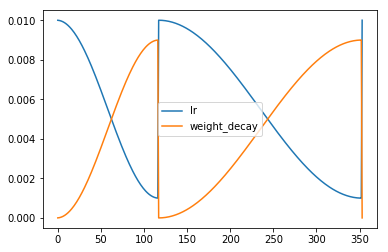

In [12]:
pd.DataFrame(results['callbacks']['scheduler'].parameter_history('lr', 'weight_decay')).plot()

The results are promising but not as good as our simplistic model. Let's see what can we get if unfreeze the backbone layers and train the model with differential learning rates:

In [13]:
torch.save(model, 'frozen.model')

In [17]:
model = torch.load('frozen.model')

In [18]:
model.freeze_backbone(False)
opt = AdamW([
    {'params': model.backbone.parameters(), 'lr': 1e-4, 'weigth_decay': 1e-5},
    {'params': model.top.parameters(), 'lr': 1e-3, 'weigth_decay': 1e-3}
])

In [19]:
results = train_classifier(model, opt, (train_ds, valid_ds), 
                           epochs=1, batch_size=512,
                           schedule_params={'schedule': 'one_cycle'},
                           num_workers=(12, 4))

Epoch:    1 | train_loss=0.0507, train_accuracy=0.9789, valid_loss=0.0209, valid_accuracy=0.9931


We're getting even closer the top entries of the scoreboard! It seems that our training loop and schedulers help us go in a right direction.

## CIFAR10

The CIFAR10 dataset is a more challenging task. Though modern deep learning architectures are capable to show quite good results even in this case. Therefore, it is also a good candidate to check how well performs the written code.

The process is the same as for MNIST:

1. Create datasets and data loaders
2. Initialize optimizer and schedulers
3. Start the training process 

In [30]:
root = data_path('cifar10')

image_size = 224

train_ds = CIFAR10(
    root, train=True, download=True,
    transform=T.Compose([T.Resize(image_size),
                         T.Pad(8, padding_mode='reflect'),
                         T.RandomAffine(5, translate=(0.05, 0.05), scale=(0.8, 1.2)),
                         T.RandomResizedCrop(image_size, scale=(0.8, 1.1)),
                         T.RandomHorizontalFlip(),
                         T.ToTensor(), 
                         T.Normalize(*imagenet_stats)]))

valid_ds = CIFAR10(
    root, train=False, download=True,
    transform=T.Compose([T.Resize(image_size),
                         T.ToTensor(), 
                         T.Normalize(*imagenet_stats)]))

model = FineTunedModel(n_out=10, arch=resnet34)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
opt = AdamW(model.parameters())
lrs, losses = find_lr(model, opt, train_ds, batch_size=1024, loss_fn=F.cross_entropy)

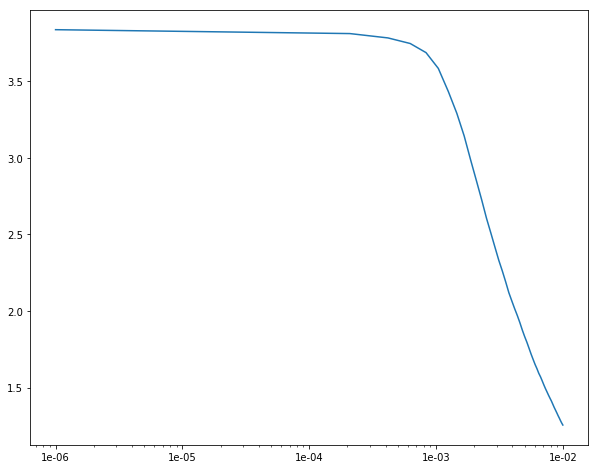

In [26]:
plot.lr_loss_curve(lrs, losses)

In [ ]:
opt = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
results = train_classifier(model, opt, (train_ds, valid_ds), 
                           epochs=20, batch_size=1024, num_workers=12)